In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from glob import glob
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dropout, Activation, UpSampling2D, GlobalMaxPooling2D, multiply
from tensorflow.keras.backend import max
from keras_unet_collection import models, base, utils

2023-04-22 10:28:48.485599: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import time
import sys
sys.path.insert(0,'../..')
from gp2 import Runner

2023-04-22 10:28:50.060603: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-22 10:28:50.497359: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-22 10:28:50.506305: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:0f:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-22 10:28:50.506393: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-22 10:28:50.510570: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-22 

In [4]:
R = Runner(verbose=True, classifier='kunet2d')

2023-04-22 10:28:50.594600: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-22 10:28:50.988764: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-22 10:28:50.992690: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:0f:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-22 10:28:51.007853: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible 

*** GP2  KUNet2D ***
Working directory: /tmp/tmpkuz68ifsGP2
Verbose mode active!
Model: "unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
unet_down0_0 (Conv2D)           (None, 512, 512, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
unet_down0_0_bn (BatchNormaliza (None, 512, 512, 32) 128         unet_down0_0[0][0]               
__________________________________________________________________________________________________
unet_down0_0_activation (ReLU)  (None, 512, 512, 32) 0           unet_down0_0_bn[0][0]            
________

In [5]:
# load our larger toy dataset (10k images and masks)
images = np.load('/hpcstor6/scratch01/r/ryan.zurrin001/GP2TOYEXAMPLE_LARGE/images.npy')
masks = np.load('/hpcstor6/scratch01/r/ryan.zurrin001/GP2TOYEXAMPLE_LARGE/masks.npy')

In [6]:
images = images[:5000]
masks = masks[:5000]

In [7]:
images.shape

(5000, 512, 512, 1)

In [8]:
masks.shape

(5000, 512, 512, 1)

In [9]:
print(images.max())

255


In [10]:
print(images.min())

0


In [11]:
print(masks.max())

True


In [12]:
weights = {
    'A': 0.5,
    'A_train': 0.1,
    'A_val': 0.3,
    'A_test': 0.6,
    'B': 0.3,
    'B_train': 0.7,
    'B_val': 0.1,
    'B_test': 0.2,
    'Z': 0.2
}
PERCENT_TO_REPLACE = 30

In [13]:
R.setup_data(images, masks, dataset_size=5000, weights=weights)

Weights OK!


In [14]:
RUNS = 5

In [15]:
for run in range(RUNS):
    print('***')
    print('RUN:', run)
    t0 = time.time()
    R.run_classifier(patience_counter=2)
    R.run_discriminator()
    l = R.find_machine_labels()
    if l == 0:
        print('No more machine labels.')
        print('TOOK', time.time()-t0, 'seconds')
        break
    R.relabel(percent_to_replace=PERCENT_TO_REPLACE)
    print('TOOK', time.time()-t0, 'seconds')
    

***
RUN: 0


2023-04-22 10:29:03.565726: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-22 10:29:03.587029: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245755000 Hz


Epoch 1/100


2023-04-22 10:29:07.645941: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-22 10:29:08.352598: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-04-22 10:29:09.059048: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-04-22 10:29:09.059075: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-04-22 10:29:09.059134: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-22 10:29:09.067168: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-22 10:29:09.783043: I tensorflow/stream_exec

250/250 [==============================] - 24s 62ms/step - loss: 0.1351 - dice_coef: 0.5999 - val_loss: 10.7793 - val_dice_coef: 0.2123


2023-04-22 10:29:32.269491: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
250/250 [==============================] - 15s 59ms/step - loss: 0.0918 - dice_coef: 0.7076 - val_loss: 14.3605 - val_dice_coef: 0.1773
Epoch 3/100
250/250 [==============================] - 15s 61ms/step - loss: 0.0638 - dice_coef: 0.8051 - val_loss: 12.1170 - val_dice_coef: 0.1897
Epoch 4/100
250/250 [==============================] - 15s 59ms/step - loss: 0.0522 - dice_coef: 0.8468 - val_loss: 1.4863 - val_dice_coef: 8.7392e-04
Epoch 5/100
250/250 [==============================] - 15s 60ms/step - loss: 0.0505 - dice_coef: 0.8573 - val_loss: 1.4916 - val_dice_coef: 2.0061e-06
Epoch 6/100
250/250 [==============================] - 15s 60ms/step - loss: 0.0549 - dice_coef: 0.8535 - val_loss: 1.3323 - val_dice_coef: 0.0476
Epoch 7/100
250/250 [==============================] - 15s 62ms/step - loss: 0.0578 - dice_coef: 0.8462 - val_loss: 0.2410 - val_dice_coef: 0.5240
Epoch 8/100
250/250 [==============================] - 15s 62ms/step - loss: 0.0536 - dice_coef: 0.8457 - va

Replacing 52 from 156 !
D_relabeled_ 52
selected_ids ['2bebeb39-0527-4911-bc91-ace21cf9cdc8', 'fcff159d-2286-4e2a-98ba-849ada6ace01', '7dd64417-9bb0-42a1-a21b-f3842c3c8cd6', '103e5fa7-4d76-4537-9591-d8340582706f', '61a5c2c5-81f6-4401-af70-d737828f1677', 'ac2b067d-b1f4-467f-b5c1-726fdbae5948', '8b7c7043-c57c-4770-a51e-01598cd54747', 'b1c66d23-9791-4b8c-8969-2b56cdefc7ae', 'a61bce07-a9ed-44b0-8fa7-817e035be64d', 'a0fbd920-c3f9-46d2-ab3c-e1bcb3761931', 'd9859d13-3fd3-4682-a1ad-d1446c456a47', '6e6c3f67-f1bf-440d-9d1c-35d78790124c', '5df4e8b8-81a0-4d82-b2e8-ff8c91dc57de', '0f03c6d7-6618-4fa4-8fde-166cd031268c', '7202a91d-e262-49e5-95f3-24a90d1fa771', '6c3ad8af-eb09-4ac3-9bbf-9fad32c3e7dd', '335dc6db-c678-43cd-bbbd-618ca96aec23', 'd4ffe965-45d5-4c2f-8459-ed211b5d04cd', 'ad1012ed-88ef-4e3e-a206-1b39355852a3', 'de03e3db-3063-40d9-a8ce-8f2f3f64384f', '742dd71c-5043-472d-b127-a980407ef60a', 'f67ec5a4-a9b9-4fe1-8e8c-e0705f44ba76', 'e127d3f4-d1bf-4a2d-9682-88361f4efd37', '6acc07d5-6f31-4291-81d2-c

Epoch 1/100
319/319 [==============================] - 17s 53ms/step - loss: 0.0569 - dice_coef: 0.8559 - val_loss: 0.3998 - val_dice_coef: 0.6547
Epoch 2/100
319/319 [==============================] - 17s 53ms/step - loss: 0.0648 - dice_coef: 0.8319 - val_loss: 0.5319 - val_dice_coef: 0.6567
Epoch 3/100
319/319 [==============================] - 18s 56ms/step - loss: 0.0647 - dice_coef: 0.8343 - val_loss: 0.6903 - val_dice_coef: 0.6498
Epoch 4/100
319/319 [==============================] - 17s 54ms/step - loss: 0.0566 - dice_coef: 0.8565 - val_loss: 0.6580 - val_dice_coef: 0.6559
Epoch 5/100
319/319 [==============================] - 17s 53ms/step - loss: 0.0572 - dice_coef: 0.8637 - val_loss: 0.5385 - val_dice_coef: 0.6706
Epoch 6/100
319/319 [==============================] - 17s 53ms/step - loss: 0.0584 - dice_coef: 0.8640 - val_loss: 0.4727 - val_dice_coef: 0.6752
Epoch 7/100
319/319 [==============================] - 16s 50ms/step - loss: 0.0590 - dice_coef: 0.8642 - val_loss: 0.

Removed: 13 Filled: 13
TOOK 410.7585904598236 seconds
***
RUN: 4
Epoch 1/100
349/349 [==============================] - 19s 53ms/step - loss: 0.0595 - dice_coef: 0.8694 - val_loss: 0.2560 - val_dice_coef: 0.7374
Epoch 2/100
349/349 [==============================] - 18s 52ms/step - loss: 0.0595 - dice_coef: 0.8694 - val_loss: 0.2787 - val_dice_coef: 0.7281
Epoch 3/100
349/349 [==============================] - 18s 51ms/step - loss: 0.0595 - dice_coef: 0.8694 - val_loss: 0.3083 - val_dice_coef: 0.7227
Epoch 4/100
349/349 [==============================] - 18s 51ms/step - loss: 0.0595 - dice_coef: 0.8694 - val_loss: 0.2606 - val_dice_coef: 0.7388
Epoch 5/100
349/349 [==============================] - 17s 50ms/step - loss: 0.0595 - dice_coef: 0.8694 - val_loss: 0.2584 - val_dice_coef: 0.7361
Model saved to: /tmp/tmpkuz68ifsGP2/unet_4unet_model
History saved to: /tmp/tmpkuz68ifsGP2/unet_history_4.pkl
Testing the classifier...
Testing the discriminator...
10/10 [============================

In [16]:
R.classifier_scores

[[5.870521068572998, 0.18942545354366302],
 [0.34661784768104553, 0.5179240703582764],
 [0.4081608057022095, 0.5310279726982117],
 [0.27074870467185974, 0.6112017035484314],
 [0.2268027365207672, 0.6446624994277954]]

In [17]:
R.discriminator_scores

[[0.0, 1.0],
 [277.4599914550781, 0.6933333277702332],
 [255.7133331298828, 0.7066666483879089],
 [334.0133361816406, 0.6066666841506958],
 [349.64666748046875, 0.6066666841506958]]

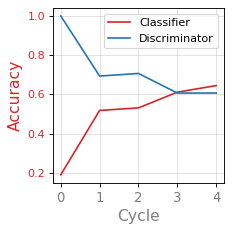

In [18]:
R.plot()

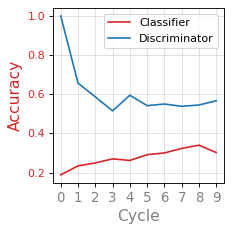

In [18]:
R.plot()

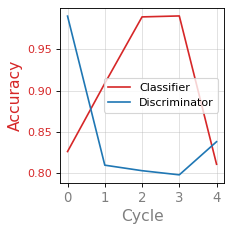

In [17]:
R.plot()